<a href="https://colab.research.google.com/github/saritmaitra/Momentum_Trading/blob/main/Weekly_Series_Momentum_Signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.gridspec as gridspec
import pandas as pd
from pandas.tseries.offsets import MonthEnd
pd.options.mode.chained_assignment = None
pd.set_option('use_inf_as_na', True)

In [2]:
from datetime import datetime
tickers=["SGRY", "NTRA", "Z", "FATE", "DIS", "GM", 'BPMC', "PTC"]
ls_key = 'Adj Close'
start = datetime(2018,1,1)
 
df = yf.download(tickers,start, freq='w')
prices = df[[("Adj Close", s) for s in tickers]]
prices.columns = prices.columns.droplevel(level=0)
prices

[*********************100%***********************]  8 of 8 completed


,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-02,13.350000,9.470000,42.480000,6.300000,108.726067,38.072212,80.010002,61.160000
2018-01-03,12.900000,9.510000,42.970001,6.500000,109.192856,39.001244,84.010002,61.939999
2018-01-04,12.900000,9.720000,42.130001,6.990000,109.144241,40.203526,78.550003,63.000000
2018-01-05,12.650000,9.900000,42.610001,6.820000,108.551003,40.085114,77.739998,63.650002
2018-01-08,13.150000,9.790000,42.759998,6.590000,106.994995,40.276390,74.639999,64.400002
...,...,...,...,...,...,...,...,...
2021-07-29,55.270000,112.160004,107.970001,86.040001,178.350006,57.279999,84.739998,133.029999
2021-07-30,54.560001,114.519997,106.260002,82.800003,176.020004,56.840000,87.870003,135.449997
2021-08-02,54.540001,112.330002,107.519997,85.080002,175.550003,57.029999,86.980003,131.070007


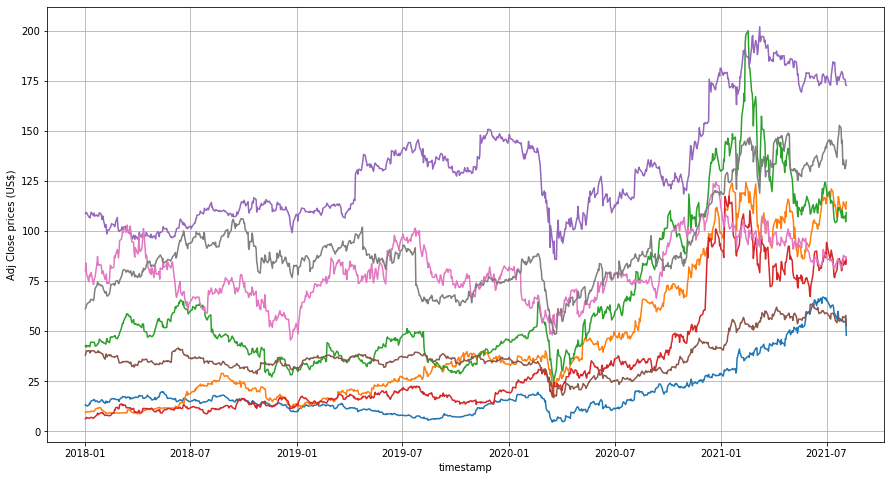

In [3]:
plt.figure(figsize= (15,8))
plt.plot(prices, label = 'Daily Closing price' )
# plt.xticks([])
plt.ylabel('Adj Close prices (US$)'); plt.xlabel('timestamp')
plt.grid(True); plt.show()

In [4]:
returns = prices.copy()
returns = returns.apply(lambda x: x.shift(-1)/x - 1, axis = 0)
returns # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-02,-0.033708,0.004224,0.011535,0.031746,0.004293,0.024402,0.049994,0.012753
2018-01-03,0.000000,0.022082,-0.019549,0.075385,-0.000445,0.030827,-0.064992,0.017113
2018-01-04,-0.019380,0.018518,0.011393,-0.024320,-0.005435,-0.002945,-0.010312,0.010317
2018-01-05,0.039526,-0.011111,0.003520,-0.033724,-0.014334,0.004772,-0.039876,0.011783
2018-01-08,0.064639,-0.002043,-0.013798,-0.004552,-0.000727,-0.003845,0.045284,0.002019
...,...,...,...,...,...,...,...,...
2021-07-29,-0.012846,0.021041,-0.015838,-0.037657,-0.013064,-0.007682,0.036937,0.018191
2021-07-30,-0.000367,-0.019123,0.011858,0.027536,-0.002670,0.003343,-0.010129,-0.032337
2021-08-02,0.034470,-0.013265,-0.027251,-0.021509,-0.014583,0.014904,-0.011382,0.010224


In [5]:
# ranking of the returns
returns_rank = returns.rank(axis=1,method='average', numeric_only=True, 
                            na_option='keep', ascending=False, pct=False)
returns_rank

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-02,8.0,7.0,5.0,2.0,6.0,3.0,1.0,4.0
2018-01-03,5.0,3.0,7.0,1.0,6.0,2.0,8.0,4.0
2018-01-04,7.0,1.0,2.0,8.0,5.0,4.0,6.0,3.0
2018-01-05,1.0,5.0,4.0,7.0,6.0,3.0,8.0,2.0
2018-01-08,1.0,5.0,8.0,7.0,4.0,6.0,2.0,3.0
...,...,...,...,...,...,...,...,...
2021-07-29,5.0,2.0,7.0,8.0,6.0,4.0,1.0,3.0
2021-07-30,4.0,7.0,2.0,1.0,5.0,3.0,6.0,8.0
2021-08-02,1.0,5.0,8.0,7.0,6.0,2.0,4.0,3.0


For each period(i), we want to calculate the average return for period(i) of the 2 stocks from the list that had the best performance over the previous period (period(i-1)).

In [6]:
# Creating a mask to select only 2 best returns per period, shifting down one line, replacing NaN in first line by false
import numpy as np
mask = (returns_rank < 3).shift(1) 
mask = mask.replace(np.nan,False)
mask

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-02,False,False,False,False,False,False,False,False
2018-01-03,False,False,False,True,False,False,True,False
2018-01-04,False,False,False,True,False,True,False,False
2018-01-05,False,True,True,False,False,False,False,False
2018-01-08,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...
2021-07-29,False,False,False,False,False,True,True,False
2021-07-30,False,True,False,False,False,False,True,False
2021-08-02,False,False,True,True,False,False,False,False


In [7]:
# Applying the mask to the returns
best_returns = returns[mask]
best_returns

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,NaN,NaN,NaN,0.075385,NaN,NaN,-0.064992,NaN
2018-01-04,NaN,NaN,NaN,-0.024320,NaN,-0.002945,NaN,NaN
2018-01-05,NaN,-0.011111,0.003520,NaN,NaN,NaN,NaN,NaN
2018-01-08,0.064639,NaN,NaN,NaN,NaN,NaN,NaN,0.002019
...,...,...,...,...,...,...,...,...
2021-07-29,NaN,NaN,NaN,NaN,NaN,-0.007682,0.036937,NaN
2021-07-30,NaN,-0.019123,NaN,NaN,NaN,NaN,-0.010129,NaN
2021-08-02,NaN,NaN,-0.027251,-0.021509,NaN,NaN,NaN,NaN


In [8]:
# averaging the returns :
average_return = best_returns.mean(axis=1, skipna='true')
average_return 

Date
2018-01-02         NaN
2018-01-03    0.005196
2018-01-04   -0.013633
2018-01-05   -0.003795
2018-01-08    0.033329
                ...   
2021-07-29    0.014628
2021-07-30   -0.014626
2021-08-02   -0.024380
2021-08-03   -0.119371
2021-08-04         NaN
Length: 904, dtype: float64

## Momentun signal computation:

In [9]:
momentum_signal = prices.copy()

"""
return of the securities of last 6 weeks prior to the week we will be trading
we are not using current weeks because:
1. traditional momentum has atendency of short term reversal and longer term trend
2. it algns with execution strategy interms of  consistent with actual execution because
if we receive a signal on close price, we won't be able to execute immedeate
"""
momentum_signal = (momentum_signal.apply(func = lambda x: x.shift(1)/x.shift(7) - 1, axis = 0))
momentum_signal # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-29,-0.057961,0.034685,0.020928,0.009161,0.013296,-0.011754,-0.035594,0.016018
2021-07-30,-0.077141,-0.042104,-0.033047,0.002564,0.008254,0.004032,-0.010047,-0.091945
2021-08-02,-0.024495,-0.019688,-0.039501,-0.036761,0.005082,0.021567,0.028923,-0.086526


In [10]:
rank_df = momentum_signal.rank(axis =1)
rank_df # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-29,1.0,8.0,7.0,4.0,5.0,3.0,2.0,6.0
2021-07-30,2.0,3.0,4.0,6.0,8.0,7.0,5.0,1.0
2021-08-02,4.0,5.0,2.0,3.0,6.0,7.0,8.0,1.0


### creating signal >= 7 means 1, <=2 means -1, else 0

In [11]:
for col in rank_df.columns:
    rank_df[col] = np.where(rank_df[col] >= 7.0, 1, np.where(rank_df[col] <= 2.0, -1, 0))

rank_df.tail() # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2021-07-29,-1,1,1,0,0,0,-1,0
2021-07-30,-1,0,0,0,1,1,0,-1
2021-08-02,0,0,-1,0,0,1,1,-1
2021-08-03,0,0,-1,0,0,1,1,-1
2021-08-04,0,0,-1,0,0,1,1,-1


In [12]:
portfolio = np.multiply(rank_df, returns)
portfolio.tail(50) # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2021-05-25,0.000000,0.010386,0.000000,-0.023147,0.000000,0.023256,0.000000,-0.001052
2021-05-26,0.000000,-0.033493,0.000000,0.002877,0.014563,0.000000,-0.000000,0.001355
2021-05-27,0.003429,-0.016960,0.017078,-0.004590,-0.000000,-0.000000,-0.000000,0.000000
2021-05-28,0.022040,-0.000000,-0.000000,0.054047,0.000000,0.005733,0.023974,-0.000000
2021-06-01,-0.023236,0.015761,-0.000000,0.048578,-0.000000,0.000000,0.022768,-0.000000
2021-06-02,0.015403,0.013055,-0.000000,0.024514,-0.000000,0.000000,0.011821,-0.000000
2021-06-03,0.020563,0.029999,0.000000,-0.082379,0.000000,-0.000000,0.016028,0.000000
2021-06-04,0.041949,0.000000,0.000000,-0.057838,-0.000000,-0.002209,-0.000354,0.000000
2021-06-07,-0.000000,0.023588,-0.004531,0.000000,-0.000000,0.010913,-0.008024,0.000000


In [13]:
portfolio_returns = portfolio.sum(axis=1) / 3
portfolio_returns

Date
2018-01-02    0.000000
2018-01-03    0.000000
2018-01-04    0.000000
2018-01-05    0.000000
2018-01-08    0.000000
                ...   
2021-07-29   -0.006296
2021-07-30    0.011125
2021-08-02    0.006850
2021-08-03   -0.047904
2021-08-04    0.000000
Length: 904, dtype: float64

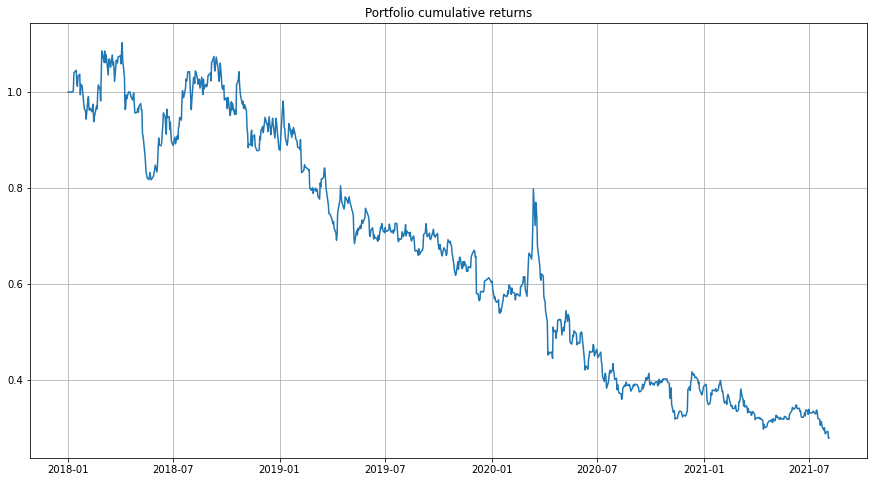

In [14]:
cum_returns = np.exp(np.log1p(portfolio_returns).cumsum())

plt.figure(figsize= (15,8))
plt.plot(cum_returns)
plt.title('Portfolio cumulative returns')
plt.grid(True); plt.show()